# GSPHAR Model Input Inspection

This notebook focuses specifically on examining the input shapes, data transformation, and actual values that are fed into the GSPHAR model. It provides a detailed look at how time series data is processed and structured for the model.

In [1]:
# Import libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader

# Add the parent directory to the path to import from the GSPHAR package
sys.path.insert(0, os.path.abspath('..'))

# Import from local modules
from config import settings
from src.data import load_data, split_data, create_lagged_features
from src.utils.date_aware_dataset import IndexMappingDataset

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 1. Load and Prepare Data

In [2]:
# Load cryptocurrency realized volatility data
data_file = '../data/rv5_sqrt_38_crypto.csv'

# Custom loading for crypto data which has 'Open Time' as the date column
try:
    data = pd.read_csv(data_file, parse_dates=['Open Time'])
    data.set_index('Open Time', inplace=True)
    data = data * 100  # Scale by 100 to match the convention in load_data
except Exception as e:
    print(f"Error loading cryptocurrency data with custom loader: {e}")
    print("Falling back to standard load_data function")
    data = load_data(data_file)

# Display basic information about the data
print(f"Data shape: {data.shape}")
print(f"Date range: {data.index[0]} to {data.index[-1]}")
print(f"Number of cryptocurrencies: {data.shape[1]}")
print(f"Cryptocurrencies: {', '.join(data.columns.tolist()[:5])}...")

# Display the first few rows
data.head()

Data shape: (1609, 38)
Date range: 2020-08-22 00:00:00+00:00 to 2025-01-16 00:00:00+00:00
Number of cryptocurrencies: 38
Cryptocurrencies: BTCUSDT, ETHUSDT, BCHUSDT, XRPUSDT, EOSUSDT...


,BTCUSDT,ETHUSDT,BCHUSDT,XRPUSDT,EOSUSDT,LTCUSDT,TRXUSDT,ETCUSDT,LINKUSDT,XLMUSDT,...,ZRXUSDT,COMPUSDT,DOGEUSDT,SXPUSDT,KAVAUSDT,BANDUSDT,RLCUSDT,MKRUSDT,SNXUSDT,DOTUSDT
Open Time,,,,,,,,,,,,,,,,,,,,,
2020-08-22 00:00:00+00:00,1.188588,2.376909,2.183935,2.226062,3.005365,2.679520,4.334443,2.547645,6.506429,3.072503,...,10.490731,7.357899,2.809609,10.165309,9.966780,12.030800,7.056605,6.636861,9.562576,23.470294
2020-08-23 00:00:00+00:00,1.374606,2.857603,2.794364,2.595456,3.307818,3.820546,4.672181,2.559989,7.342115,3.284224,...,11.112461,6.217943,3.012421,10.550130,9.318212,9.623774,7.902518,2.920807,7.285702,15.660378
2020-08-24 00:00:00+00:00,1.276306,3.142906,3.368280,2.433362,3.156814,3.680510,3.973526,2.500816,5.490624,4.023327,...,7.181548,6.927003,3.156002,10.738898,6.815674,6.289313,5.721871,6.297053,6.400687,12.994270
2020-08-25 00:00:00+00:00,2.477261,4.735685,4.088918,3.359801,5.923342,4.757542,6.100788,3.700474,7.893401,4.416728,...,9.476592,8.584583,4.052704,12.143326,8.088786,7.835709,10.507126,5.840057,10.459917,15.805384
2020-08-26 00:00:00+00:00,2.046636,3.410478,3.157540,2.907803,3.338440,3.155623,4.519064,2.934152,7.522230,4.095250,...,8.154979,7.242337,2.796226,9.855504,7.537690,12.364135,7.558324,4.248290,8.744210,14.872644


In [3]:
# Split data into train and test sets
train_dataset_raw, test_dataset_raw = split_data(data, train_ratio=0.8)

print(f"Train data shape: {train_dataset_raw.shape}")
print(f"Train date range: {train_dataset_raw.index[0]} to {train_dataset_raw.index[-1]}")
print(f"Test data shape: {test_dataset_raw.shape}")
print(f"Test date range: {test_dataset_raw.index[0]} to {test_dataset_raw.index[-1]}")

Train data shape: (1287, 38)
Train date range: 2020-08-22 00:00:00+00:00 to 2024-02-29 00:00:00+00:00
Test data shape: (322, 38)
Test date range: 2024-03-01 00:00:00+00:00 to 2025-01-16 00:00:00+00:00


In [4]:
# Select a subset of cryptocurrencies for analysis
# Using the top 10 by market cap for a more focused analysis
# Make sure these are actually in the dataset
all_cryptos = data.columns.tolist()
top_cryptos_candidates = ['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'XRPUSDT', 'ADAUSDT', 
                          'DOGEUSDT', 'DOTUSDT', 'LTCUSDT', 'LINKUSDT', 'XLMUSDT']

# Filter to only include cryptos that are in the dataset
top_cryptos = [crypto for crypto in top_cryptos_candidates if crypto in all_cryptos]
print(f"Using these cryptocurrencies: {top_cryptos}")

# Filter data to include only selected cryptocurrencies
train_data_subset = train_dataset_raw[top_cryptos]
test_data_subset = test_dataset_raw[top_cryptos]

# Get market indices
market_indices_list = top_cryptos

# Set prediction horizon
h = 5  # 5-day ahead prediction

Using these cryptocurrencies: ['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'XRPUSDT', 'ADAUSDT', 'DOGEUSDT', 'DOTUSDT', 'LTCUSDT', 'LINKUSDT', 'XLMUSDT']


## 2. Create Lagged Features

Now we'll create the lagged features that will be used as input to the model. This is a critical step in the data transformation process.

In [5]:
# Create lagged features
try:
    train_dataset = create_lagged_features(
        train_data_subset,
        market_indices_list,
        h,
        settings.LOOK_BACK_WINDOW
    )
    test_dataset = create_lagged_features(
        test_data_subset,
        market_indices_list,
        h,
        settings.LOOK_BACK_WINDOW
    )
    
    print(f"Train dataset with lagged features shape: {train_dataset.shape}")
    print(f"Test dataset with lagged features shape: {test_dataset.shape}")
    
    # Display the column names to see the lagged features
    print("\nFirst 20 column names:")
    print(train_dataset.columns[:20])
    
    # Display the first few rows of the dataset with lagged features
    print("\nFirst few rows of the dataset with lagged features:")
    display(train_dataset.head())
except Exception as e:
    print(f"Error creating lagged features: {e}")

Train dataset with lagged features shape: (1261, 230)
Test dataset with lagged features shape: (296, 230)

First 20 column names:
Index(['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'XRPUSDT', 'ADAUSDT', 'DOGEUSDT',
       'DOTUSDT', 'LTCUSDT', 'LINKUSDT', 'XLMUSDT', 'BTCUSDT_1', 'BTCUSDT_2',
       'BTCUSDT_3', 'BTCUSDT_4', 'BTCUSDT_5', 'BTCUSDT_6', 'BTCUSDT_7',
       'BTCUSDT_8', 'BTCUSDT_9', 'BTCUSDT_10'],
      dtype='object')

First few rows of the dataset with lagged features:


,BTCUSDT,ETHUSDT,BNBUSDT,XRPUSDT,ADAUSDT,DOGEUSDT,DOTUSDT,LTCUSDT,LINKUSDT,XLMUSDT,...,XLMUSDT_13,XLMUSDT_14,XLMUSDT_15,XLMUSDT_16,XLMUSDT_17,XLMUSDT_18,XLMUSDT_19,XLMUSDT_20,XLMUSDT_21,XLMUSDT_22
Open Time,,,,,,,,,,,,,,,,,,,,,
2020-09-17 00:00:00+00:00,1.835332,4.316814,5.852456,4.399933,4.160503,2.611250,5.771652,3.599987,7.888872,3.601003,...,2.412552,2.451744,2.337349,2.815329,4.448876,4.095250,4.416728,4.023327,3.284224,3.072503
2020-09-18 00:00:00+00:00,1.497796,3.126338,6.422998,2.870037,3.080478,2.131749,4.737827,2.254975,5.737800,2.774798,...,3.466596,2.412552,2.451744,2.337349,2.815329,4.448876,4.095250,4.416728,4.023327,3.284224
2020-09-19 00:00:00+00:00,1.556322,2.461374,3.708454,2.708861,2.602613,1.834421,5.138281,1.980343,4.806479,2.308624,...,5.866472,3.466596,2.412552,2.451744,2.337349,2.815329,4.448876,4.095250,4.416728,4.023327
2020-09-20 00:00:00+00:00,1.826843,3.094881,5.694969,2.774396,3.701717,2.633154,7.376942,3.112518,6.335386,3.291685,...,8.667517,5.866472,3.466596,2.412552,2.451744,2.337349,2.815329,4.448876,4.095250,4.416728
2020-09-21 00:00:00+00:00,2.577429,4.847807,8.804233,3.734049,5.511992,4.526521,9.880792,4.185484,9.605853,4.546773,...,8.184475,8.667517,5.866472,3.466596,2.412552,2.451744,2.337349,2.815329,4.448876,4.095250


## 3. Create Date-Aware Datasets

Now we'll create the date-aware datasets that will be used to feed data into the model. This step organizes the lagged features into the specific tensor structures expected by the model.

In [6]:
# Create datasets directly using IndexMappingDataset
try:
    lag_list = list(range(1, settings.LOOK_BACK_WINDOW + 1))
    
    train_dataset_indexed = IndexMappingDataset(
        train_dataset,
        lag_list,
        h
    )
    
    test_dataset_indexed = IndexMappingDataset(
        test_dataset,
        lag_list,
        h
    )
    
    # Create dataloaders
    batch_size = settings.BATCH_SIZE
    dataloader_train = DataLoader(
        train_dataset_indexed,
        batch_size=batch_size,
        shuffle=True
    )
    
    dataloader_test = DataLoader(
        test_dataset_indexed,
        batch_size=batch_size,
        shuffle=False
    )
    
    print(f"Train dataset length: {len(train_dataset_indexed)}")
    print(f"Test dataset length: {len(test_dataset_indexed)}")
    print(f"Number of batches in train dataloader: {len(dataloader_train)}")
    print(f"Number of batches in test dataloader: {len(dataloader_test)}")
except Exception as e:
    print(f"Error creating dataloaders: {e}")

Train dataset length: 1235
Test dataset length: 270
Number of batches in train dataloader: 39
Number of batches in test dataloader: 9


## 4. Inspect Model Inputs

Now let's examine the actual tensors that are fed into the model. This will give us a clear understanding of the input shapes and values.

In [7]:
# Get a single batch from the test dataloader
for batch in dataloader_test:
    x_lag1, x_lag5, x_lag22, y = batch
    break  # Just get the first batch

# Print shapes
print("\n===== MODEL INPUT SHAPES =====\n")
print(f"x_lag1 shape: {x_lag1.shape}")
print(f"x_lag5 shape: {x_lag5.shape}")
print(f"x_lag22 shape: {x_lag22.shape}")
print(f"y shape: {y.shape}")

# Explain the dimensions
print("\n===== DIMENSION EXPLANATION =====\n")
print(f"x_lag1: [batch_size={x_lag1.shape[0]}, time_steps={x_lag1.shape[1]}, features={x_lag1.shape[2]}]")
print(f"x_lag5: [batch_size={x_lag5.shape[0]}, time_steps={x_lag5.shape[1]}, features={x_lag5.shape[2]}]")
print(f"x_lag22: [batch_size={x_lag22.shape[0]}, time_steps={x_lag22.shape[1]}, features={x_lag22.shape[2]}]")
print(f"y: [batch_size={y.shape[0]}, prediction_horizon={y.shape[1]}, features={y.shape[2]}]")


===== MODEL INPUT SHAPES =====

x_lag1 shape: torch.Size([32, 1, 230])
x_lag5 shape: torch.Size([32, 5, 230])
x_lag22 shape: torch.Size([32, 22, 230])
y shape: torch.Size([32, 5, 230])

===== DIMENSION EXPLANATION =====

x_lag1: [batch_size=32, time_steps=1, features=230]
x_lag5: [batch_size=32, time_steps=5, features=230]
x_lag22: [batch_size=32, time_steps=22, features=230]
y: [batch_size=32, prediction_horizon=5, features=230]


In [8]:
# Function to safely display tensor data
def display_tensor_sample(tensor, name, sample_idx=0, max_rows=5, max_cols=10):
    print(f"\n===== {name} TENSOR SAMPLE =====\n")
    print(f"Shape: {tensor.shape}")
    
    # Convert to numpy for easier handling
    sample = tensor[sample_idx].numpy()
    
    # Create a DataFrame with appropriate columns
    if sample.ndim == 1:
        # 1D tensor - just show as a single row
        print(f"First {min(max_cols, len(sample))} values: {sample[:max_cols]}")
        if len(sample) > max_cols:
            print(f"Last {min(max_cols, len(sample))} values: {sample[-max_cols:]}")
    elif sample.ndim == 2:
        # 2D tensor - show as a table with row and column indices
        rows, cols = sample.shape
        
        # Show a subset of the data
        display_rows = min(rows, max_rows)
        display_cols = min(cols, max_cols)
        
        print(f"Showing first {display_rows} rows and first {display_cols} columns:")
        subset = sample[:display_rows, :display_cols]
        
        # Create a DataFrame for better display
        df = pd.DataFrame(subset)
        display(df)
        
        if cols > max_cols:
            print(f"... and {cols - max_cols} more columns")
        if rows > max_rows:
            print(f"... and {rows - max_rows} more rows")
    else:
        print(f"Cannot display tensor with {sample.ndim} dimensions")

# Display tensor samples
display_tensor_sample(x_lag1, "x_lag1 (MOST RECENT LAG)")
display_tensor_sample(x_lag5, "x_lag5 (5-DAY LAGS)")
display_tensor_sample(x_lag22, "x_lag22 (22-DAY LAGS)")
display_tensor_sample(y, "y (TARGET VALUES)")


===== x_lag1 (MOST RECENT LAG) TENSOR SAMPLE =====

Shape: torch.Size([32, 1, 230])
Showing first 1 rows and first 10 columns:


,0,1,2,3,4,5,6,7,8,9
0,4.231649,4.470437,4.355042,4.675797,5.758779,6.660243,5.57485,4.280426,5.436482,4.900214


... and 220 more columns

===== x_lag5 (5-DAY LAGS) TENSOR SAMPLE =====

Shape: torch.Size([32, 5, 230])
Showing first 5 rows and first 10 columns:


,0,1,2,3,4,5,6,7,8,9
0,6.503388,9.453224,12.294989,16.524595,15.166750,18.834324,14.853904,10.387884,13.240593,14.034436
1,4.574713,5.788852,5.583262,6.970720,8.039493,10.335395,8.097651,7.349231,8.028666,7.336152
2,3.572882,4.146172,4.315957,5.115792,6.225300,8.679522,6.175909,5.631153,6.135162,5.463916
3,3.997185,4.576726,4.542499,4.994085,6.675868,7.777534,6.399901,5.320744,6.085192,5.434981
4,4.231649,4.470437,4.355042,4.675797,5.758779,6.660243,5.574850,4.280426,5.436482,4.900214


... and 220 more columns

===== x_lag22 (22-DAY LAGS) TENSOR SAMPLE =====

Shape: torch.Size([32, 22, 230])
Showing first 5 rows and first 10 columns:


,0,1,2,3,4,5,6,7,8,9
0,3.157713,3.378302,2.639222,2.795192,3.900666,7.454860,4.042572,5.166939,3.674887,3.591161
1,2.469257,2.716087,2.837923,3.407959,3.208059,9.652112,3.161378,4.179544,3.185928,2.930875
2,1.865316,2.315927,4.621248,3.572975,3.753495,6.384804,3.769284,6.361060,3.059994,4.719254
3,1.162038,1.833333,2.183207,2.218152,2.621963,5.496235,2.632575,3.563848,2.618808,2.696814
4,1.637909,2.102257,1.534304,1.420779,1.787531,5.130271,2.087102,3.401706,2.177334,1.827172


... and 220 more columns
... and 17 more rows

===== y (TARGET VALUES) TENSOR SAMPLE =====

Shape: torch.Size([32, 5, 230])
Showing first 5 rows and first 10 columns:


,0,1,2,3,4,5,6,7,8,9
0,3.601453,3.579449,4.049573,3.645700,5.120936,6.332784,4.922534,3.956121,4.835523,4.289456
1,5.148406,5.058278,3.885916,5.304559,6.384603,7.090626,6.133854,5.270746,6.605408,5.304151
2,2.299280,2.581707,2.267207,3.136768,4.632793,5.043875,3.607749,2.967970,3.806946,2.870245
3,1.944860,2.418468,2.255528,2.830395,3.624978,4.595444,3.262564,2.763180,3.674436,2.819908
4,2.620735,2.811203,3.199604,3.796541,4.085211,4.065681,3.895874,2.837677,4.192430,3.020973


... and 220 more columns


In [9]:
# Print statistics for each input tensor
print("\n===== INPUT TENSOR STATISTICS =====\n")
print(f"x_lag1 mean: {x_lag1.mean().item():.4f}, std: {x_lag1.std().item():.4f}, min: {x_lag1.min().item():.4f}, max: {x_lag1.max().item():.4f}")
print(f"x_lag5 mean: {x_lag5.mean().item():.4f}, std: {x_lag5.std().item():.4f}, min: {x_lag5.min().item():.4f}, max: {x_lag5.max().item():.4f}")
print(f"x_lag22 mean: {x_lag22.mean().item():.4f}, std: {x_lag22.std().item():.4f}, min: {x_lag22.min().item():.4f}, max: {x_lag22.max().item():.4f}")
print(f"y mean: {y.mean().item():.4f}, std: {y.std().item():.4f}, min: {y.min().item():.4f}, max: {y.max().item():.4f}")


===== INPUT TENSOR STATISTICS =====

x_lag1 mean: 4.2229, std: 2.3802, min: 1.1256, max: 18.8343
x_lag5 mean: 4.2786, std: 2.3914, min: 1.1256, max: 18.8343
x_lag22 mean: 4.4694, std: 2.3974, min: 1.1256, max: 23.3766
y mean: 4.1162, std: 2.3059, min: 1.1256, max: 18.8343


## 5. Visualize Input Data

Let's visualize the input data to better understand the structure and patterns.

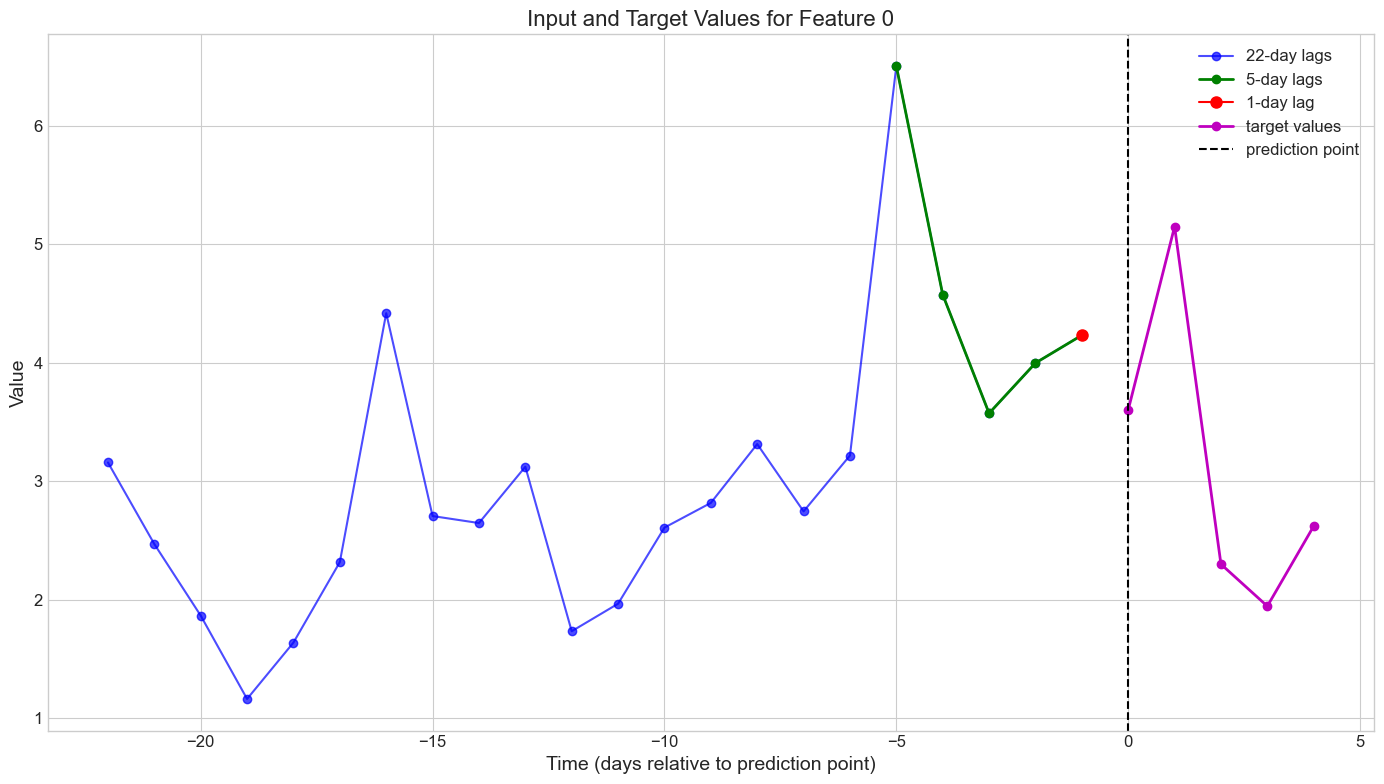

In [10]:
# Visualize a single feature across all lags
feature_idx = 0  # Just use the first feature
sample_idx = 0   # First sample in the batch

plt.figure(figsize=(14, 8))

# Extract values for the selected feature
lag1_values = x_lag1[sample_idx, :, feature_idx].numpy().flatten()
lag5_values = x_lag5[sample_idx, :, feature_idx].numpy().flatten()
lag22_values = x_lag22[sample_idx, :, feature_idx].numpy().flatten()
target_values = y[sample_idx, :, feature_idx].numpy().flatten()

# Create x-axis values (days relative to prediction)
lag1_x = [-1]  # Most recent lag
lag5_x = list(range(-5, 0))  # 5-day lags
lag22_x = list(range(-22, 0))  # 22-day lags
target_x = list(range(len(target_values)))  # Future values

# Plot
plt.plot(lag22_x, lag22_values, 'bo-', label='22-day lags', alpha=0.7)
plt.plot(lag5_x, lag5_values, 'go-', label='5-day lags', linewidth=2)
plt.plot(lag1_x, lag1_values, 'ro-', label='1-day lag', markersize=8)
plt.plot(target_x, target_values, 'mo-', label='target values', linewidth=2)

plt.axvline(x=0, color='k', linestyle='--', label='prediction point')
plt.title(f'Input and Target Values for Feature {feature_idx}', fontsize=16)
plt.xlabel('Time (days relative to prediction point)', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

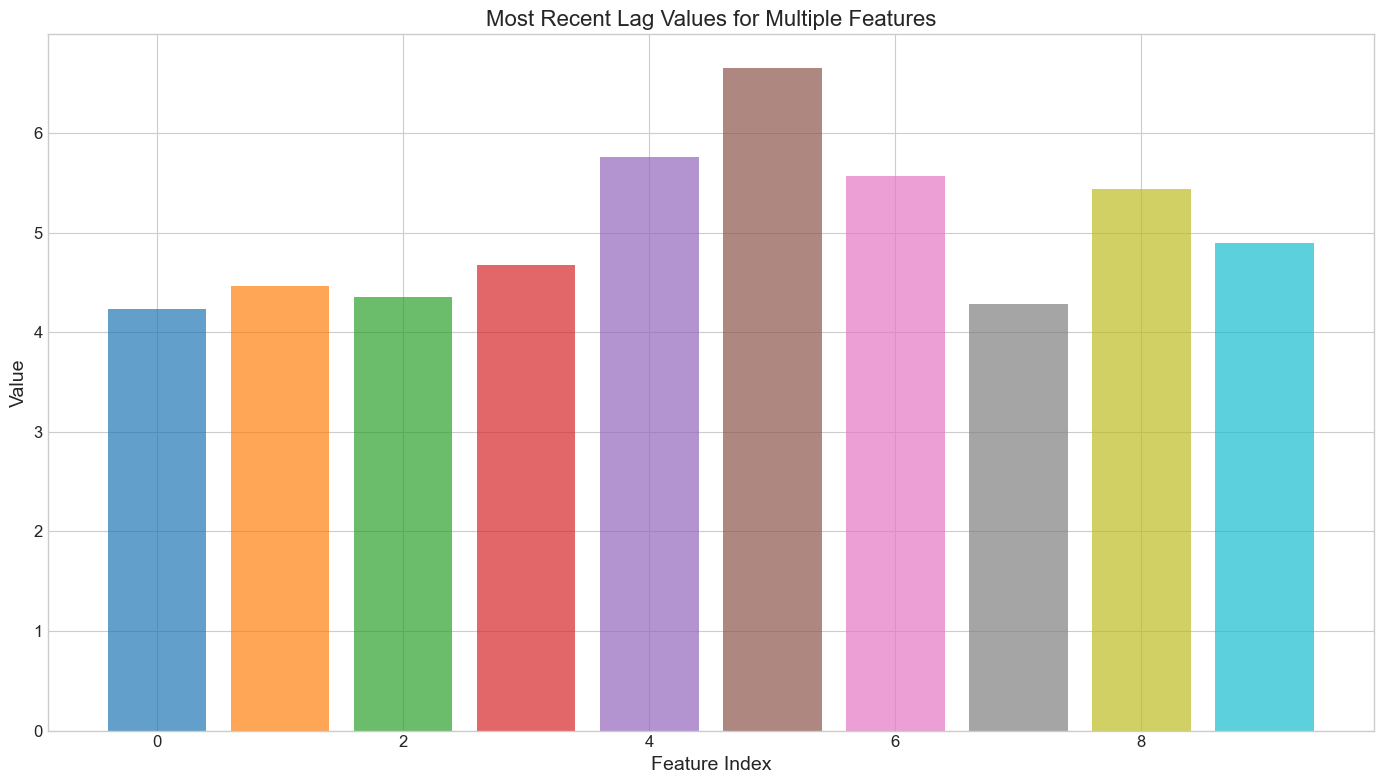

In [11]:
# Visualize multiple features for the most recent lag
sample_idx = 0  # First sample in the batch
num_features = min(10, x_lag1.shape[2])  # Show up to 10 features

plt.figure(figsize=(14, 8))

# Extract values for multiple features
for i in range(num_features):
    feature_values = x_lag1[sample_idx, 0, i].item()
    plt.bar(i, feature_values, alpha=0.7)

plt.title('Most Recent Lag Values for Multiple Features', fontsize=16)
plt.xlabel('Feature Index', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

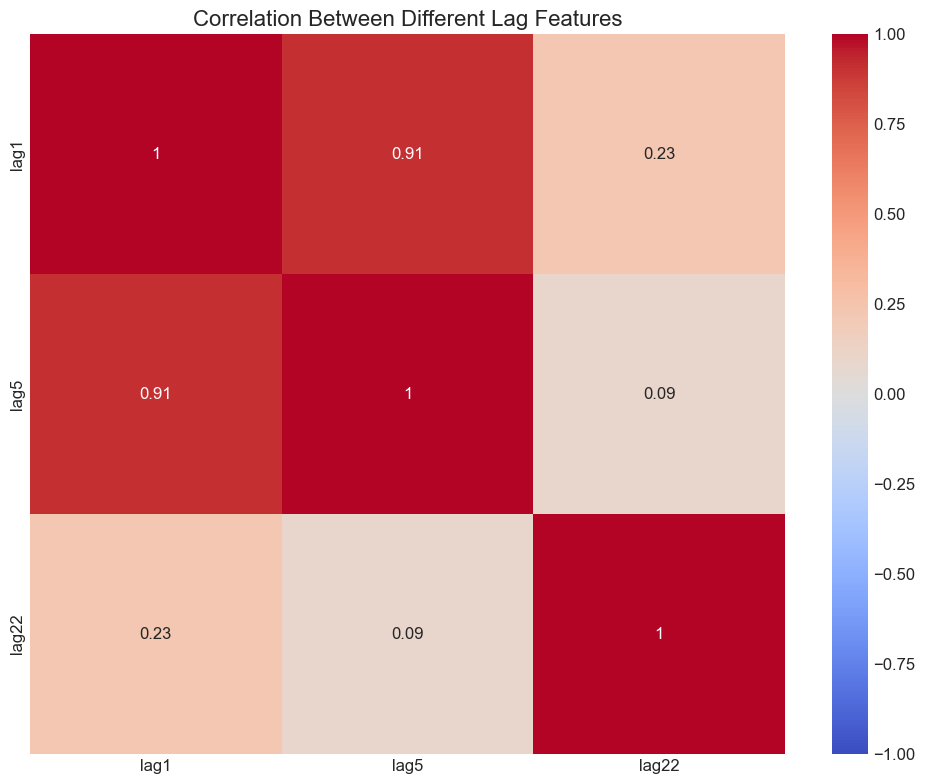

In [12]:
# Visualize the correlation between features
sample_idx = 0  # First sample in the batch
time_idx = 0    # Most recent time step
num_features = min(20, x_lag1.shape[2])  # Show up to 20 features

# Extract feature values from all three lag tensors
lag1_features = x_lag1[sample_idx, 0, :num_features].numpy()
lag5_features = x_lag5[sample_idx, 0, :num_features].numpy()  # Most recent of the 5-day lags
lag22_features = x_lag22[sample_idx, 0, :num_features].numpy()  # Most recent of the 22-day lags

# Create a DataFrame with these features
feature_df = pd.DataFrame({
    'lag1': lag1_features,
    'lag5': lag5_features,
    'lag22': lag22_features
})

# Calculate and visualize the correlation matrix
corr_matrix = feature_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Between Different Lag Features', fontsize=16)
plt.tight_layout()
plt.show()

## 6. Summary of Model Input Structure

Based on our inspection, here's a summary of the GSPHAR model's input structure:

1. **Input Tensors**:
   - `x_lag1`: Shape [batch_size, 1, num_features] - Most recent lag (t-1)
   - `x_lag5`: Shape [batch_size, 5, num_features] - 5-day lags (t-5 to t-1)
   - `x_lag22`: Shape [batch_size, 22, num_features] - 22-day lags (t-22 to t-1)

2. **Target Tensor**:
   - `y`: Shape [batch_size, horizon, num_features] - Future values (t to t+horizon-1)

3. **Data Transformation Process**:
   - Raw time series data → Split into train/test → Create lagged features → Create date-aware datasets → Generate batches

4. **Key Characteristics**:
   - Multi-scale approach captures both short-term and long-term patterns
   - Date-aware datasets maintain the connection between tensor indices and actual dates
   - Features show varying degrees of correlation across different time scales

This structure allows the GSPHAR model to effectively capture temporal dependencies and cross-cryptocurrency relationships for volatility forecasting.